# Solving a Fourth Order Elliptic Singular Perturbation Problem

$$
\left\{\begin{array}{lr}
\varepsilon^{2} \Delta^{2} u-\Delta u=f & \text { in } \Omega \\
u=\partial_{n} u=0 & \text { on } \partial \Omega
\end{array}\right.
$$

In [51]:
from skfem import *
import numpy as np
from skfem.visuals.matplotlib import draw, plot
from skfem.utils import solver_iter_krylov
from skfem.helpers import d, dd, ddd, dot, ddot, grad, dddot, prod
from scipy.sparse.linalg import LinearOperator, minres
from skfem import *
from skfem.models.poisson import *
from skfem.assembly import BilinearForm, LinearForm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.dpi'] = 100

pi = np.pi
sin = np.sin
cos = np.cos
exp = np.exp

## Problem 2

The modified Morley-Wang-Xu element method is also equivalent to
$$
\begin{aligned}
\left(\nabla w_{h}, \nabla \chi_{h}\right) &=\left(f, \chi_{h}\right) & & \forall \chi_{h} \in W_{h} \\
\varepsilon^{2} \tilde{a}_{h}\left(u_{h}, v_{h}\right)+b_{h}\left(u_{h}, v_{h}\right) &=\left(\nabla w_{h}, \nabla_{h} v_{h}\right) & & \forall v_{h} \in V_{h}
\end{aligned}
$$
where
$$
\tilde{a}_{h}\left(u_{h}, v_{h}\right):=\left(\nabla_{h}^{2} u_{h}, \nabla_{h}^{2} v_{h}\right)-\sum_{F \in \mathcal{F}_{h}^{\partial}}\left(\partial_{n n}^{2} u_{h}, \partial_{n} v_{h}\right)_{F}-\sum_{F \in \mathcal{F}_{h}^{\partial}}\left(\partial_{n} u_{h}, \partial_{n n}^{2} v_{h}\right)_{F}+\sum_{F \in \mathcal{F}_{h}^{0}} \frac{\sigma}{h_{F}}\left(\partial_{n} u_{h}, \partial_{n} v_{h}\right)_{F}
$$

### Setting $\epsilon$ and generating mesh

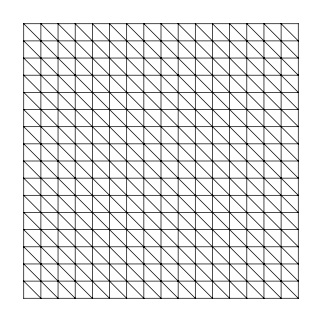

In [52]:
epsilon = 0

# m = MeshTri.init_symmetric()
m = MeshTri()
m.refine(4)
element = {'w': ElementTriP1(), 'u': ElementTriMorley()}
basis = {variable: InteriorBasis(m, e, intorder=4)
    for variable, e in element.items()}  # intorder: integration order for quadrature

draw(m)
plt.show()

### Forms for $\left(\nabla w_{h}, \nabla \chi_{h}\right)=\left(f, \chi_{h}\right)$

In [53]:
@BilinearForm
def laplace(u, v, w):
    '''
    for $(\nabla w_{h}, \nabla \chi_{h})$
    '''
    return dot(grad(u), grad(v))


@LinearForm
def f_load(v, w):
    '''
    for $(f, x_{h})$
    '''
    pix = pi * w.x[0]
    piy = pi * w.x[1]
    lu = 2 * (pi)**2 * (cos(2*pix)*((sin(piy))**2) + cos(2*piy)*((sin(pix))**2))
    llu = - 8 * (pi)**4 * (cos(2*pix)*sin(piy)**2 + cos(2*piy)*sin(pix)**2 - cos(2*pix)*cos(2*piy))
    return (epsilon**2 * llu - lu) * v

### Solving $w_{h}$

In [54]:
%%time

K1 = asm(laplace, basis['w'])
f1 = asm(f_load, basis['w'])

wh = solve(*condense(K1, f1, D=m.boundary_nodes()), solver=solver_iter_krylov(Precondition=True))

Wall time: 5.98 ms


### Forms for $\varepsilon^{2} a_{h}\left(u_{h 0}, v_{h}\right)+b_{h}\left(u_{h 0}, v_{h}\right)=\left(\nabla w_{h}, \nabla_{h} v_{h}\right)$

$$
a_{h}\left(u_{h 0}, v_{h}\right):=\left(\nabla_{h}^{2} u_{h 0}, \nabla_{h}^{2} v_{h}\right), \quad b_{h}\left(u_{h 0}, v_{h}\right):=\left(\nabla_{h} u_{h 0}, \nabla_{h} v_{h}\right)
$$

In [55]:
@BilinearForm
def a_load(u, v, w):
    '''
    for $a_{h}$
    '''
    return ddot(dd(u), dd(v))


@BilinearForm
def b_load(u, v, w):
    '''
    for $b_{h}$
    '''
    return dot(grad(u), grad(v))


@BilinearForm
def wv_load(u, v, w):
    '''
    for $(\nabla \chi_{h}, \nabla_{h} v_{h})$
    '''
    return dot(grad(u), grad(v))

### Setting boundary conditions

In [56]:
def easy_boundary(basis):
    '''
    Input basis
    ----------------
    Return D for boundary conditions
    '''

    dofs = basis.find_dofs({
        'left': m.facets_satisfying(lambda x: x[0] == 0),
        'right': m.facets_satisfying(lambda x: x[0] == 1),
        'top': m.facets_satisfying(lambda x: x[1] == 1),
        'buttom': m.facets_satisfying(lambda x: x[1] == 0)
    })

    D = np.concatenate((dofs['left'].nodal['u'], dofs['right'].nodal['u'],
                        dofs['top'].nodal['u'], dofs['buttom'].nodal['u']))
    return D

### Adding penalty

In [57]:
sigma = 5
gamma1 = 1e-3
gamma2 = gamma1

def divM(T): # input K
    return np.array([T[0, 0, 0] + T[0, 1, 1], T[1, 0, 0] + T[1, 1, 1]])

def gradM(T): # input K
    return np.array([[[T[0, 0, 0] , T[0, 0, 1]],
                   [T[0, 1, 0], T[0, 1, 1]]],
                  [[T[1, 0, 0], T[1, 0, 1]],
                   [T[1, 1, 0], T[1, 1, 1]]]])

def Mnn(ddu, n):
    return ddot(-ddu, prod(n, n))

@BilinearForm
def penalty_1(u, v, w):
    return gamma1 * ddot(-dd(u), prod(w.n, w.n)) * dot(grad(v), w.n)

@BilinearForm
def penalty_2(u, v, w):
    return gamma2 * ddot(-dd(v), prod(w.n, w.n)) * dot(grad(u), w.n)

@BilinearForm
def penalty_3(u, v, w):
    return (sigma/w.h)*dot(grad(u), w.n)*dot(grad(v), w.n)

### Solving $u_{h0}$

In [58]:
%%time

fbasis = FacetBasis(m, element['u'])
p1 = asm(penalty_1, fbasis)
p2 = asm(penalty_2, fbasis)
p3 = asm(penalty_3, fbasis)
P = -p1 - p2 + p3

D = easy_boundary(basis['u'])
K2 = epsilon**2 * asm(a_load, basis['u']) + asm(b_load, basis['u'])
f2 = asm(wv_load, basis['w'], basis['u']) * wh
uh0 = solve(*condense(K2 + P, f2, D=D),
            solver=solver_iter_krylov(Precondition=True))  # cg

Wall time: 45.9 ms


### Computing $L_{2}$ $H_{1}$ $H_{2}$ error with $u_{h0}$ and $u$

In [59]:
def exact_u(x, y):
    return (sin(pi * x) * sin(pi * y))**2

def dexact_u(x, y):
    dux = 2 * pi * cos(pi * x) * sin(pi * x) * sin(pi * y)**2
    duy = 2 * pi * cos(pi * y) * sin(pi * x)**2 * sin(pi * y)
    return dux, duy

def ddexact(x, y):
    duxx = 2*pi**2*cos(pi*x)**2*sin(pi*y)**2 - 2*pi**2*sin(pi*x)**2*sin(pi*y)**2
    duxy = 2*pi*cos(pi*x)*sin(pi*x)*2*pi*cos(pi*y)*sin(pi*y)
    duyx = duxy
    duyy = 2*pi**2*cos(pi*y)**2*sin(pi*x)**2 - 2*pi**2*sin(pi*y)**2*sin(pi*x)**2
    return duxx, duxy, duyx, duyy

@Functional
def L2uError(w):
    x, y = w.x
    return (w.w - exact_u(x, y))**2

def get_DuError(basis, u):
    duh = basis.interpolate(u).grad
    x = basis.global_coordinates().value
    dx = basis.dx  # quadrature weights
    dux, duy = dexact_u(x[0], x[1])
    return np.sqrt(np.sum(((duh[0] - dux)**2 + (duh[1] - duy)**2) * dx))

def get_D2uError(basis, u):
    dduh = basis.interpolate(u).hess
    x = basis.global_coordinates().value  # coordinates of quadrature points [x, y]
    dx = basis.dx  # quadrature weights
    duxx, duxy, duyx, duyy = ddexact(x[0], x[1])
    return np.sqrt(
        np.sum(((dduh[0][0] - duxx)**2 + (dduh[0][1] - duxy)**2 +
                (dduh[1][1] - duyy)**2 + (dduh[1][0] - duyx)**2) * dx))

# Numerical results

## Parameters 
$$
\tilde{a}_{h}\left(u_{h}, v_{h}\right):=\left(\nabla_{h}^{2} u_{h}, \nabla_{h}^{2} v_{h}\right)-\sum_{F \in \mathcal{F}_{h}^{\partial}}\left(\partial_{n n}^{2} u_{h}, \partial_{n} v_{h}\right)_{F}-\sum_{F \in \mathcal{F}_{h}^{\partial}}\left(\partial_{n} u_{h}, \partial_{n n}^{2} v_{h}\right)_{F}+\sum_{F \in \mathcal{F}_{h}^{0}} \frac{\sigma}{h_{F}}\left(\partial_{n} u_{h}, \partial_{n} v_{h}\right)_{F}
$$


- `gamma1` times $\sum_{F \in \mathcal{F}_{h}^{\partial}}\left(\partial_{n n}^{2} u_{h}, \partial_{n} v_{h}\right)_{F}$
- `gamma2` times $\sum_{F \in \mathcal{F}_{h}^{\partial}}\left(\partial_{n} u_{h}, \partial_{n n}^{2} v_{h}\right)_{F}$
- `sigma` in $\sum_{F \in \mathcal{F}_{h}^{0}} \frac{\sigma}{h_{F}}\left(\partial_{n} u_{h}, \partial_{n} v_{h}\right)_{F}$

## Example 1
Using example 
$$
u\left(x_{1}, x_{2}\right)=\left(\sin \left(\pi x_{1}\right) \sin \left(\pi x_{2}\right)\right)^{2}
$$

In [73]:
gamma1 = 1
gamma2 = 1
sigma = 5
for i in range(6):  
    epsilon = 1*10**(-i)

    L2_list = []
    Du_list = []
    D2u_list = []
    h_list = []
    epu_list = []
    m = MeshTri()

    for i in range(1, 7):
        m.refine()

        element = {'w': ElementTriP1(), 'u': ElementTriMorley()}
        basis = {variable: InteriorBasis(m, e, intorder=4)
            for variable, e in element.items()}  # intorder: integration order for quadrature

        K1 = asm(laplace, basis['w'])
        f1 = asm(f_load, basis['w'])

        wh = solve(*condense(K1, f1, D=m.boundary_nodes()), solver=solver_iter_krylov(Precondition=True))


        fbasis = FacetBasis(m, element['u'])
        p1 = asm(penalty_1, fbasis)
        p2 = asm(penalty_2, fbasis)
        p3 = asm(penalty_3, fbasis)
        P = -p1 - p2 + p3

        
        K2 = epsilon**2 * asm(a_load, basis['u']) + asm(b_load, basis['u'])
        f2 = asm(wv_load, basis['w'], basis['u']) * wh
        uh0 = solve(*condense(K2 + P, f2, D=easy_boundary(basis['u'])), solver=solver_iter_krylov(Precondition=True))  # cg
        
        U = basis['u'].interpolate(uh0).value

        L2u = np.sqrt(L2uError.assemble(basis['u'], w=U))
        Du = get_DuError(basis['u'], uh0)
        H1u = Du + L2u
        D2u = get_D2uError(basis['u'], uh0)
        H2u = Du + L2u + D2u
        epu = np.sqrt(epsilon**2 * D2u**2 + Du**2)
        h_list.append(m.param())
        Du_list.append(Du)
        L2_list.append(L2u)
        D2u_list.append(D2u)
        epu_list.append(epu)

    hs = np.array(h_list)
    L2s = np.array(L2_list)
    Dus = np.array(Du_list)
    D2us = np.array(D2u_list)
    epus = np.array(epu_list)
    H1s = L2s + Dus
    H2s = H1s + D2us
    print('epsilon =', epsilon)
    print('  h    L2u   H1u   H2u   epu')
    for i in range(H2s.shape[0] - 1):
        print(
            '2^-' + str(i + 2),
            ' {:.2f}  {:.2f}  {:.2f}  {:.2f}'.format(-np.log2(L2s[i + 1] / L2s[i]),
                                                    -np.log2(H1s[i + 1] / H1s[i]),
                                                    -np.log2(H2s[i + 1] / H2s[i]),
                                                    -np.log2(epus[i + 1] / epus[i])))

epsilon = 1
  h    L2u   H1u   H2u   epu
2^-2  0.08  0.45  0.61  0.63
2^-3  -0.05  -0.04  0.43  0.48
2^-4  0.51  0.43  0.32  0.31
2^-5  0.76  0.72  0.39  0.35
2^-6  0.88  0.86  0.45  0.41
epsilon = 0.1
  h    L2u   H1u   H2u   epu
2^-2  -0.38  -0.16  -0.19  -0.15
2^-3  1.59  1.52  0.92  1.16
2^-4  1.45  1.40  0.74  0.87
2^-5  1.26  1.24  0.65  0.70
2^-6  1.14  1.13  0.58  0.60
epsilon = 0.01
  h    L2u   H1u   H2u   epu
2^-2  0.04  0.23  0.06  0.27
2^-3  1.71  1.55  0.52  1.49
2^-4  1.94  1.64  0.67  1.52
2^-5  1.92  1.59  0.71  1.36
2^-6  1.75  1.48  0.66  1.09
epsilon = 0.001
  h    L2u   H1u   H2u   epu
2^-2  0.04  0.23  0.06  0.27
2^-3  1.71  1.54  0.49  1.51
2^-4  1.96  1.64  0.59  1.58
2^-5  2.00  1.62  0.61  1.56
2^-6  2.00  1.58  0.58  1.53
epsilon = 0.0001
  h    L2u   H1u   H2u   epu
2^-2  0.04  0.23  0.06  0.27
2^-3  1.71  1.54  0.49  1.51
2^-4  1.96  1.64  0.59  1.58
2^-5  2.00  1.62  0.60  1.57
2^-6  2.00  1.58  0.57  1.54
epsilon = 1e-05
  h    L2u   H1u   H2u   epu
2^-2 

In [74]:
gamma1 = 0
gamma2 = 0
sigma = 0
for i in range(6):  
    epsilon = 1*10**(-i)

    L2_list = []
    Du_list = []
    D2u_list = []
    h_list = []
    epu_list = []
    m = MeshTri()

    for i in range(1, 7):
        m.refine()

        element = {'w': ElementTriP1(), 'u': ElementTriMorley()}
        basis = {variable: InteriorBasis(m, e, intorder=4)
            for variable, e in element.items()}  # intorder: integration order for quadrature

        K1 = asm(laplace, basis['w'])
        f1 = asm(f_load, basis['w'])

        wh = solve(*condense(K1, f1, D=m.boundary_nodes()), solver=solver_iter_krylov(Precondition=True))


        fbasis = FacetBasis(m, element['u'])
        p1 = asm(penalty_1, fbasis)
        p2 = asm(penalty_2, fbasis)
        p3 = asm(penalty_3, fbasis)
        P = -p1 - p2 + p3

        D = easy_boundary(basis['u'])
        K2 = epsilon**2 * asm(a_load, basis['u']) + asm(b_load, basis['u'])
        f2 = asm(wv_load, basis['w'], basis['u']) * wh
        uh0 = solve(*condense(K2 + P, f2, D=D), solver=solver_iter_krylov(Precondition=True))  # cg
        
        U = basis['u'].interpolate(uh0).value

        L2u = np.sqrt(L2uError.assemble(basis['u'], w=U))
        Du = get_DuError(basis['u'], uh0)
        H1u = Du + L2u
        D2u = get_D2uError(basis['u'], uh0)
        H2u = Du + L2u + D2u
        epu = np.sqrt(epsilon**2 * D2u**2 + Du**2)
        h_list.append(m.param())
        Du_list.append(Du)
        L2_list.append(L2u)
        D2u_list.append(D2u)
        epu_list.append(epu)

    hs = np.array(h_list)
    L2s = np.array(L2_list)
    Dus = np.array(Du_list)
    D2us = np.array(D2u_list)
    epus = np.array(epu_list)
    H1s = L2s + Dus
    H2s = H1s + D2us
    print('epsilon =', epsilon)
    print('  h    L2u   H1u   H2u   epu')
    for i in range(H2s.shape[0] - 1):
        print(
            '2^-' + str(i + 2),
            ' {:.2f}  {:.2f}  {:.2f}  {:.2f}'.format(-np.log2(L2s[i + 1] / L2s[i]),
                                                    -np.log2(H1s[i + 1] / H1s[i]),
                                                    -np.log2(H2s[i + 1] / H2s[i]),
                                                    -np.log2(epus[i + 1] / epus[i])))

epsilon = 1
  h    L2u   H1u   H2u   epu
2^-2  0.06  -0.10  0.11  0.14
2^-3  -0.14  -0.15  0.09  0.12
2^-4  -0.04  -0.05  0.03  0.04
2^-5  -0.01  -0.01  0.01  0.01
2^-6  -0.00  -0.00  0.00  0.00
epsilon = 0.1
  h    L2u   H1u   H2u   epu
2^-2  0.99  0.53  0.28  0.34
2^-3  0.06  0.58  0.55  0.59
2^-4  -0.10  0.08  0.30  0.25
2^-5  -0.03  0.00  0.10  0.07
2^-6  -0.01  -0.00  0.03  0.02
epsilon = 0.01
  h    L2u   H1u   H2u   epu
2^-2  1.25  0.58  0.20  0.50
2^-3  2.29  1.51  0.63  1.43
2^-4  2.24  1.67  0.74  1.54
2^-5  1.34  1.44  0.68  1.23
2^-6  0.10  0.77  0.47  0.65
epsilon = 0.001
  h    L2u   H1u   H2u   epu
2^-2  1.24  0.58  0.20  0.50
2^-3  2.30  1.50  0.60  1.45
2^-4  2.37  1.67  0.66  1.64
2^-5  2.22  1.66  0.63  1.64
2^-6  2.08  1.61  0.59  1.58
epsilon = 0.0001
  h    L2u   H1u   H2u   epu
2^-2  1.24  0.58  0.20  0.50
2^-3  2.30  1.50  0.60  1.45
2^-4  2.37  1.67  0.66  1.65
2^-5  2.23  1.66  0.62  1.65
2^-6  2.11  1.61  0.58  1.60
epsilon = 1e-05
  h    L2u   H1u   H2u   ep

## Example 2

$$
u=g(x)p(y)
$$
where
$$
g(x)=\frac{1}{2}\left[\sin (\pi x)+\frac{\pi \varepsilon}{1-e^{-1 / \varepsilon}}\left(e^{-x / \varepsilon}+e^{(x-1) / \varepsilon}-1-e^{-1 / \varepsilon}\right)\right]
$$
$$
p(y)=2 y\left(1-y^{2}\right)+\varepsilon\left[l d(1-2 y)-3 \frac{q}{l}+\left(\frac{3}{l}-d\right) e^{-y / \varepsilon}+\left(\frac{3}{l}+d\right) e^{(y-1) / \varepsilon}\right]
$$
$$
l=1-e^{-1 / \varepsilon}, q=2-l \text { and } d=1 /(q-2 \varepsilon l)
$$

In [28]:
@LinearForm
def f_load(v, w):
    '''
    for $(f, x_{h})$
    '''
    x = w.x[0]
    y = w.x[1]
    return ((sin(pi*x)/2 - (ep*pi*(exp(-x/ep) + exp((x - 1)/ep) - exp(-1/ep) - 1))/(2*(exp(-1/ep) - 1)))*(12*y + ep*((exp(-y/ep)*(3/(exp(-1/ep) - 1) + 1/(exp(-1/ep) + 2*ep*(exp(-1/ep) - 1) + 1)))/ep**2 + (exp((y - 1)/ep)*(3/(exp(-1/ep) - 1) - 1/(exp(-1/ep) + 2*ep*(exp(-1/ep) - 1) + 1)))/ep**2)) - ((pi**2*sin(pi*x))/2 + (ep*pi*(exp(-x/ep)/ep**2 + exp((x - 1)/ep)/ep**2))/(2*(exp(-1/ep) - 1)))*(ep*(exp((y - 1)/ep)*(3/(exp(-1/ep) - 1) - 1/(exp(-1/ep) + 2*ep*(exp(-1/ep) - 1) + 1)) + exp(-y/ep)*(3/(exp(-1/ep) - 1) + 1/(exp(-1/ep) + 2*ep*(exp(-1/ep) - 1) + 1)) - (3*exp(-1/ep) + 3)/(exp(-1/ep) - 1) - ((2*y - 1)*(exp(-1/ep) - 1))/(exp(-1/ep) + 2*ep*(exp(-1/ep) - 1) + 1)) + 2*y*(y**2 - 1)) - ep**2*(((pi**4*sin(pi*x))/2 - (ep*pi*(exp(-x/ep)/ep**4 + exp((x - 1)/ep)/ep**4))/(2*(exp(-1/ep) - 1)))*(ep*(exp((y - 1)/ep)*(3/(exp(-1/ep) - 1) - 1/(exp(-1/ep) + 2*ep*(exp(-1/ep) - 1) + 1)) + exp(-y/ep)*(3/(exp(-1/ep) - 1) + 1/(exp(-1/ep) + 2*ep*(exp(-1/ep) - 1) + 1)) - (3*exp(-1/ep) + 3)/(exp(-1/ep) - 1) - ((2*y - 1)*(exp(-1/ep) - 1))/(exp(-1/ep) + 2*ep*(exp(-1/ep) - 1) + 1)) + 2*y*(y**2 - 1)) - 2*(12*y + ep*((exp(-y/ep)*(3/(exp(-1/ep) - 1) + 1/(exp(-1/ep) + 2*ep*(exp(-1/ep) - 1) + 1)))/ep**2 + (exp((y - 1)/ep)*(3/(exp(-1/ep) - 1) - 1/(exp(-1/ep) + 2*ep*(exp(-1/ep) - 1) + 1)))/ep**2))*((pi**2*sin(pi*x))/2 + (ep*pi*(exp(-x/ep)/ep**2 + exp((x - 1)/ep)/ep**2))/(2*(exp(-1/ep) - 1))) + ep*(sin(pi*x)/2 - (ep*pi*(exp(-x/ep) + exp((x - 1)/ep) - exp(-1/ep) - 1))/(2*(exp(-1/ep) - 1)))*((exp(-y/ep)*(3/(exp(-1/ep) - 1) + 1/(exp(-1/ep) + 2*ep*(exp(-1/ep) - 1) + 1)))/ep**4 + (exp((y - 1)/ep)*(3/(exp(-1/ep) - 1) - 1/(exp(-1/ep) + 2*ep*(exp(-1/ep) - 1) + 1)))/ep**4))) * v


def exact_u(x, y):
    return -(sin(pi*x)/2 - (ep*pi*(exp(-x/ep) + exp((x - 1)/ep) - exp(-1/ep) - 1))/(2*(exp(-1/ep) - 1)))*(ep*(exp((y - 1)/ep)*(3/(exp(-1/ep) - 1) - 1/(exp(-1/ep) + 2*ep*(exp(-1/ep) - 1) + 1)) + exp(-y/ep)*(3/(exp(-1/ep) - 1) + 1/(exp(-1/ep) + 2*ep*(exp(-1/ep) - 1) + 1)) - (3*exp(-1/ep) + 3)/(exp(-1/ep) - 1) - ((2*y - 1)*(exp(-1/ep) - 1))/(exp(-1/ep) + 2*ep*(exp(-1/ep) - 1) + 1)) + 2*y*(y**2 - 1))


def dexact_u(x, y):
    dux = -((pi*cos(pi*x))/2 + (ep*pi*(exp(-x/ep)/ep - exp((x - 1)/ep)/ep))/(2*(exp(-1/ep) - 1)))*(ep*(exp((y - 1)/ep)*(3/(exp(-1/ep) - 1) - 1/(exp(-1/ep) + 2*ep*(exp(-1/ep) - 1) + 1)) + exp(-y/ep)*(3/(exp(-1/ep) - 1) + 1/(exp(-1/ep) + 2*ep*(exp(-1/ep) - 1) + 1)) - (3*exp(-1/ep) + 3)/(exp(-1/ep) - 1) - ((2*y - 1)*(exp(-1/ep) - 1))/(exp(-1/ep) + 2*ep*(exp(-1/ep) - 1) + 1)) + 2*y*(y**2 - 1))
    duy = (sin(pi*x)/2 - (ep*pi*(exp(-x/ep) + exp((x - 1)/ep) - exp(-1/ep) - 1))/(2*(exp(-1/ep) - 1)))*(ep*((2*(exp(-1/ep) - 1))/(exp(-1/ep) + 2*ep*(exp(-1/ep) - 1) + 1) + (exp(-y/ep)*(3/(exp(-1/ep) - 1) + 1/(exp(-1/ep) + 2*ep*(exp(-1/ep) - 1) + 1)))/ep - (exp((y - 1)/ep)*(3/(exp(-1/ep) - 1) - 1/(exp(-1/ep) + 2*ep*(exp(-1/ep) - 1) + 1)))/ep) - 6*y**2 + 2)
    return dux, duy


def ddexact(x, y):
    duxx = ((pi**2*sin(pi*x))/2 + (ep*pi*(exp(-x/ep)/ep**2 + exp((x - 1)/ep)/ep**2))/(2*(exp(-1/ep) - 1)))*(ep*(exp((y - 1)/ep)*(3/(exp(-1/ep) - 1) - 1/(exp(-1/ep) + 2*ep*(exp(-1/ep) - 1) + 1)) + exp(-y/ep)*(3/(exp(-1/ep) - 1) + 1/(exp(-1/ep) + 2*ep*(exp(-1/ep) - 1) + 1)) - (3*exp(-1/ep) + 3)/(exp(-1/ep) - 1) - ((2*y - 1)*(exp(-1/ep) - 1))/(exp(-1/ep) + 2*ep*(exp(-1/ep) - 1) + 1)) + 2*y*(y**2 - 1))
    duxy = ((pi*cos(pi*x))/2 + (ep*pi*(exp(-x/ep)/ep - exp((x - 1)/ep)/ep))/(2*(exp(-1/ep) - 1)))*(ep*((2*(exp(-1/ep) - 1))/(exp(-1/ep) + 2*ep*(exp(-1/ep) - 1) + 1) + (exp(-y/ep)*(3/(exp(-1/ep) - 1) + 1/(exp(-1/ep) + 2*ep*(exp(-1/ep) - 1) + 1)))/ep - (exp((y - 1)/ep)*(3/(exp(-1/ep) - 1) - 1/(exp(-1/ep) + 2*ep*(exp(-1/ep) - 1) + 1)))/ep) - 6*y**2 + 2)
    duyx = duxy
    duyy = -(sin(pi*x)/2 - (ep*pi*(exp(-x/ep) + exp((x - 1)/ep) - exp(-1/ep) - 1))/(2*(exp(-1/ep) - 1)))*(12*y + ep*((exp(-y/ep)*(3/(exp(-1/ep) - 1) + 1/(exp(-1/ep) + 2*ep*(exp(-1/ep) - 1) + 1)))/ep**2 + (exp((y - 1)/ep)*(3/(exp(-1/ep) - 1) - 1/(exp(-1/ep) + 2*ep*(exp(-1/ep) - 1) + 1)))/ep**2))
    return duxx, duxy, duyx, duyy


@Functional
def L2uError(w):
    x, y = w.x
    return (w.w - exact_u(x, y))**2


def get_DuError(basis, u):
    duh = basis.interpolate(u).grad
    x = basis.global_coordinates().value
    dx = basis.dx  # quadrature weights
    dux, duy = dexact_u(x[0], x[1])
    return np.sqrt(np.sum(((duh[0] - dux)**2 + (duh[1] - duy)**2) * dx))


def get_D2uError(basis, u):
    dduh = basis.interpolate(u).hess
    x = basis.global_coordinates(
    ).value  # coordinates of quadrature points [x, y]
    dx = basis.dx  # quadrature weights
    duxx, duxy, duyx, duyy = ddexact(x[0], x[1])
    return np.sqrt(
        np.sum(((dduh[0][0] - duxx)**2 + (dduh[0][1] - duxy)**2 +
                (dduh[1][1] - duyy)**2 + (dduh[1][0] - duyx)**2) * dx))

In [ ]:
gamma1 = 0
gamma2 = 0
sigma = 0
for i in range(6):  
    epsilon = 1*10**(-i)

    L2_list = []
    Du_list = []
    D2u_list = []
    h_list = []
    epu_list = []
    m = MeshTri()

    for i in range(1, 7):
        m.refine()

        element = {'w': ElementTriP1(), 'u': ElementTriMorley()}
        basis = {variable: InteriorBasis(m, e, intorder=4)
            for variable, e in element.items()}  # intorder: integration order for quadrature

        K1 = asm(laplace, basis['w'])
        f1 = asm(f_load, basis['w'])

        wh = solve(*condense(K1, f1, D=m.boundary_nodes()), solver=solver_iter_krylov(Precondition=True))


        fbasis = FacetBasis(m, element['u'])
        p1 = asm(penalty_1, fbasis)
        p2 = asm(penalty_2, fbasis)
        p3 = asm(penalty_3, fbasis)
        P = -p1 - p2 + p3

        K2 = epsilon**2 * asm(a_load, basis['u']) + asm(b_load, basis['u'])
        f2 = asm(wv_load, basis['w'], basis['u']) * wh
        uh0 = solve(*condense(K2 + P, f2, D=easy_boundary(basis['u'])), solver=solver_iter_krylov(Precondition=True))  # cg
        
        U = basis['u'].interpolate(uh0).value

        L2u = np.sqrt(L2uError.assemble(basis['u'], w=U))
        Du = get_DuError(basis['u'], uh0)
        H1u = Du + L2u
        D2u = get_D2uError(basis['u'], uh0)
        H2u = Du + L2u + D2u
        epu = np.sqrt(epsilon**2 * D2u**2 + Du**2)
        h_list.append(m.param())
        Du_list.append(Du)
        L2_list.append(L2u)
        D2u_list.append(D2u)
        epu_list.append(epu)

    hs = np.array(h_list)
    L2s = np.array(L2_list)
    Dus = np.array(Du_list)
    D2us = np.array(D2u_list)
    epus = np.array(epu_list)
    H1s = L2s + Dus
    H2s = H1s + D2us
    print('epsilon =', epsilon)
    print('  h    L2u   H1u   H2u   epu')
    for i in range(H2s.shape[0] - 1):
        print(
            '2^-' + str(i + 2),
            ' {:.2f}  {:.2f}  {:.2f}  {:.2f}'.format(-np.log2(L2s[i + 1] / L2s[i]),
                                                    -np.log2(H1s[i + 1] / H1s[i]),
                                                    -np.log2(H2s[i + 1] / H2s[i]),
                                                    -np.log2(epus[i + 1] / epus[i])))

In [36]:
gamma1 = 1
gamma2 = 1
sigma = 5
for i in range(6):  
    epsilon = 1*10**(-i)

    L2_list = []
    Du_list = []
    D2u_list = []
    h_list = []
    epu_list = []
    m = MeshTri()

    for i in range(1, 7):
        m.refine()

        element = {'w': ElementTriP1(), 'u': ElementTriMorley()}
        basis = {variable: InteriorBasis(m, e, intorder=4)
            for variable, e in element.items()}  # intorder: integration order for quadrature

        K1 = asm(laplace, basis['w'])
        f1 = asm(f_load, basis['w'])

        wh = solve(*condense(K1, f1, D=m.boundary_nodes()), solver=solver_iter_krylov(Precondition=True))


        fbasis = FacetBasis(m, element['u'])
        p1 = asm(penalty_1, fbasis)
        p2 = asm(penalty_2, fbasis)
        p3 = asm(penalty_3, fbasis)
        P = -p1 - p2 + p3

        K2 = epsilon**2 * asm(a_load, basis['u']) + asm(b_load, basis['u'])
        f2 = asm(wv_load, basis['w'], basis['u']) * wh
        uh0 = solve(*condense(K2 + P, f2, D=easy_boundary(basis['u'])), solver=solver_iter_krylov(Precondition=True))  # cg
        
        U = basis['u'].interpolate(uh0).value

        L2u = np.sqrt(L2uError.assemble(basis['u'], w=U))
        Du = get_DuError(basis['u'], uh0)
        H1u = Du + L2u
        D2u = get_D2uError(basis['u'], uh0)
        H2u = Du + L2u + D2u
        epu = np.sqrt(epsilon**2 * D2u**2 + Du**2)
        h_list.append(m.param())
        Du_list.append(Du)
        L2_list.append(L2u)
        D2u_list.append(D2u)
        epu_list.append(epu)

    hs = np.array(h_list)
    L2s = np.array(L2_list)
    Dus = np.array(Du_list)
    D2us = np.array(D2u_list)
    epus = np.array(epu_list)
    H1s = L2s + Dus
    H2s = H1s + D2us
    print('epsilon =', epsilon)
    print('  h    L2u   H1u   H2u   epu')
    for i in range(H2s.shape[0] - 1):
        print(
            '2^-' + str(i + 2),
            ' {:.2f}  {:.2f}  {:.2f}  {:.2f}'.format(-np.log2(L2s[i + 1] / L2s[i]),
                                                    -np.log2(H1s[i + 1] / H1s[i]),
                                                    -np.log2(H2s[i + 1] / H2s[i]),
                                                    -np.log2(epus[i + 1] / epus[i])))

epsilon = 1
  h    L2u   H1u   H2u   epu
2^-2  0.01  0.01  0.01  0.01
2^-3  -0.00  0.00  0.00  0.00
2^-4  -0.01  -0.00  -0.00  -0.00
2^-5  -0.00  -0.00  -0.00  -0.00
2^-6  -0.00  -0.00  -0.00  -0.00
epsilon = 0.1
  h    L2u   H1u   H2u   epu
2^-2  -0.28  -0.18  -0.23  -0.17
2^-3  0.49  0.38  0.14  0.28
2^-4  0.32  0.26  0.04  0.17
2^-5  0.17  0.15  0.02  0.09
2^-6  0.08  0.08  0.01  0.05
epsilon = 0.01
  h    L2u   H1u   H2u   epu
2^-2  -0.14  -0.05  -0.36  -0.03
2^-3  0.73  0.49  -0.31  0.44
2^-4  0.90  0.53  -0.31  0.45
2^-5  0.89  0.51  -0.21  0.41
2^-6  0.72  0.45  -0.13  0.32
epsilon = 0.001
  h    L2u   H1u   H2u   epu
2^-2  -0.14  -0.04  -0.37  -0.02
2^-3  0.73  0.50  -0.34  0.45
2^-4  0.91  0.54  -0.43  0.48
2^-5  0.96  0.54  -0.45  0.49
2^-6  0.98  0.53  -0.45  0.49
epsilon = 0.0001
  h    L2u   H1u   H2u   epu
2^-2  -0.14  -0.04  -0.37  -0.02
2^-3  0.73  0.50  -0.34  0.45
2^-4  0.91  0.54  -0.43  0.48
2^-5  0.96  0.54  -0.46  0.49
2^-6  0.98  0.53  -0.48  0.49
epsilon = 1e-05